In [2]:
import pandas as pd
import networkx as nx
import numpy as np


df = pd.read_csv('geo_routes.csv')
df.columns = df.columns.str.strip()

# G contains the airports as nodes and the routes as directed edges



G = nx.DiGraph()

# Add nodes and edges to the graph
unfound_airport_codes = set()

for index, row in df.iterrows():
    source_airport = row['source airport']
    destination_airport = row['destination apirport']  # for some reason `destination airport` is spelled wrong in the spreadsheet
    airline_code = row['airline']
    num_stops = row['stops']
    # equipment_used = row['equipment']

    airline = row['Airline Name']
    alliance = row['Flight Alliance']

    src_lat = row['lat_src']
    src_lng = row['lng_src']
    src_elev = row['elevation_src']

    dest_lat = row['lat_dest']
    dest_lng = row['lng_dest']
    dest_elev = row['elevation_dest']


    # I wanted to add equipment but it seems that b/c the equipment_used row is full of different types of data values
    # it can't be imported into Gephi

    
    # add nodes for the airports if they are not already in the graph
    
    
    
    if row['source airport'] not in G:
        G.add_node(source_airport, airline = airline_code, stops = num_stops, latitude=src_lat, longitude=src_lng, elevation=src_elev)
    if row['destination apirport'] not in G:
        G.add_node(destination_airport, airline = airline_code, stops = num_stops, latitude=dest_lat, longitude=dest_lng, elevation=dest_elev)
    
    # Add a directed edge from Source to Destination
    G.add_edge(source_airport, destination_airport, airline_name=airline, flight_alliance=alliance)






nx.write_graphml(G, "network.graphml")

/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_80337/2819152980.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  3425
Number of edges:  37595

Average degree:  21.953284671532845
Average degree (alternate calculation) 21.953284671532845

Minimum degree:  1
Maximum degree:  477


In [4]:
# find number of strongly and weakly connected components
num_strongly_connected = nx.number_strongly_connected_components(G)
num_weakly_connected = nx.number_weakly_connected_components(G)

# find largest strongly and weakly connected components
largest_strongly_connected = max(nx.strongly_connected_components(G), key=len)
largest_weakly_connected = max(nx.weakly_connected_components(G), key=len)

print("Number of strongly connected components:", num_strongly_connected)
print("Number of weakly connected components:", num_weakly_connected)
print("Size of the largest strongly connected component:", len(largest_strongly_connected))
print("Size of the largest weakly connected component:", len(largest_weakly_connected))


Number of strongly connected components: 44
Number of weakly connected components: 8
Size of the largest strongly connected component: 3354
Size of the largest weakly connected component: 3397


In [5]:
density = nx.density(G)
print("Network density:", density)


Network density: 0.003205795074698138


In [6]:
# idk if i even doing this right, just some stastic that looked interesting.
avg_clustering = nx.average_clustering(G.to_undirected())
print("Average clustering coefficient:", avg_clustering)


Average clustering coefficient: 0.4870933566129556


In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [8]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

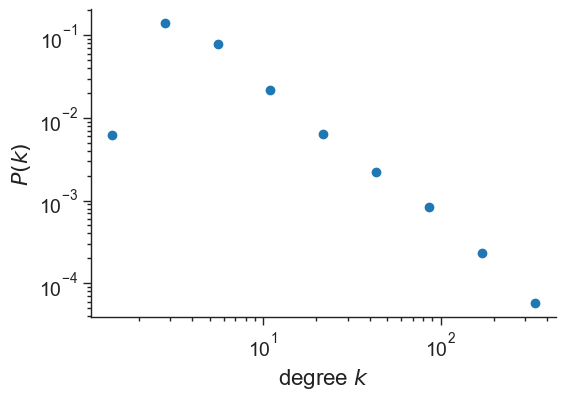

In [9]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [10]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

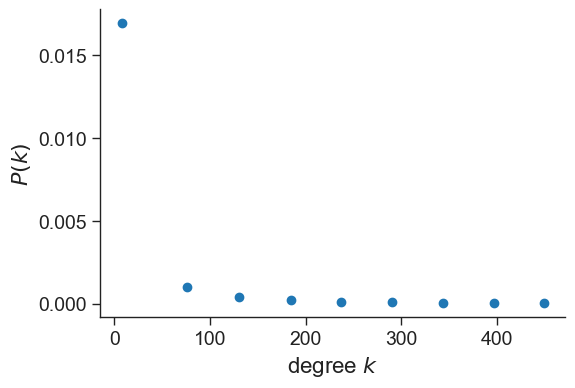

In [11]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

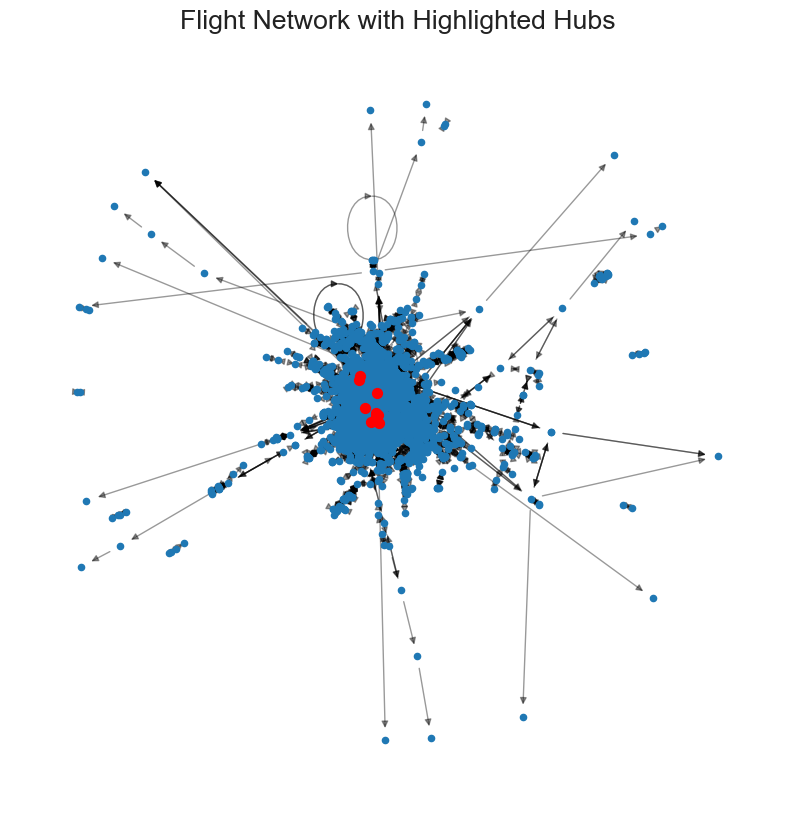

In [15]:
# Example for a simple network visualization highlighting hubs
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Highlight hubs
hub_nodes = centrality_df.head(10)['Airport']  # Top 10 hubs for illustration
nx.draw_networkx_nodes(G, pos, nodelist=hub_nodes, node_color='r', node_size=50)

plt.title('Flight Network with Highlighted Hubs')
plt.axis('off')
plt.show()

In [19]:
print(centrality_df)

     Airport  Centrality
502      FRA    0.139311
449      CDG    0.137266
227      AMS    0.135222
797      IST    0.133470
202      ATL    0.126460
...      ...         ...
1896     FMI    0.000292
2175     TUA    0.000292
2695     BVS    0.000292
87       KPR    0.000292
2409     KZI    0.000292

[3425 rows x 2 columns]


In [32]:
import pycountry
import pycountry_convert as pc
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import tqdm
import json
import os

cache_file_path = 'geocode_cache.json'

# Check if the cache file exists and load it, or initialize an empty cache
if os.path.exists(cache_file_path):
    with open(cache_file_path, 'r') as cache_file:
        geocode_cache = json.load(cache_file)
else:
    geocode_cache = {}




geolocator = Nominatim(user_agent="flight-route-analysis@eric.mao")

# Define a rate-limiter to avoid overloading the geocoding service
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=2)

def get_country_continent(coords):
    # Check cache first
    if coords in geocode_cache:
        return geocode_cache[coords]['country'], geocode_cache[coords]['continent']
    
    # If not in cache, perform geocoding
    location = geocode(coords, language='en')
    if location:
        address = location.raw['address']
        country_name = address.get('country', '')
        try:
            country_code = pycountry.countries.lookup(country_name).alpha_2
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            continent_name = pc.convert_continent_code_to_continent_name(continent_code)
            
            # Update cache
            geocode_cache[coords] = {'country': country_name, 'continent': continent_name}
            
            # Save the updated cache to the file
            with open(cache_file_path, 'w') as cache_file:
                json.dump(geocode_cache, cache_file, indent=4)
            
            return country_name, continent_name
        except (LookupError, KeyError):
            print(f"Could not determine continent for {country_name}")
            return country_name, ''
    return '', ''


# create a dictionary mapping airport -> country.
for index, row in final_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    coords = f"{latitude}, {longitude}"
    country, continent = get_country_continent(coords)

   



Could not determine continent for Turkey
Could not determine continent for Russia
Could not determine continent for Russia
Could not determine continent for Russia
Could not determine continent for Turkey
Could not determine continent for Russia
Could not determine continent for Russia
Could not determine continent for Turkey
Could not determine continent for Russia
Could not determine continent for Turkey
Could not determine continent for Turkey
Could not determine continent for Russia
Could not determine continent for Sint Maarten
Could not determine continent for Russia
Could not determine continent for Turkey
Could not determine continent for Russia
Could not determine continent for Russia
Could not determine continent for Russia
Could not determine continent for Russia
Could not determine continent for Russia
Could not determine continent for Turkey
Could not determine continent for Russia
Could not determine continent for Curacao
Could not determine continent for Russia
Could not

In [42]:
# Calculate in-degree and out-degree for each node (airport) in the graph
in_degree_dict = dict(G.in_degree())  # Returns a dictionary with nodes and their in-degree
out_degree_dict = dict(G.out_degree())  # Returns a dictionary with nodes and their out-degree

# Calculate total degree by adding in-degree and out-degree
total_degree_dict = {node: in_degree + out_degree_dict[node] for node, in_degree in in_degree_dict.items()}

# Calculate the highest degree centrality and merge it with latitude, longitude, elevation data.
airports_info = pd.concat([
    df[['source airport', 'lat_src', 'lng_src', 'elevation_src']].rename(columns={
        'source airport': 'Airport',
        'lat_src': 'Latitude',
        'lng_src': 'Longitude',
        'elevation_src': 'Elevation'
    }),
    df[['destination apirport', 'lat_dest', 'lng_dest', 'elevation_dest']].rename(columns={
        'destination apirport': 'Airport',
        'lat_dest': 'Latitude',
        'lng_dest': 'Longitude',
        'elevation_dest': 'Elevation'
    })
]).drop_duplicates('Airport').reset_index(drop=True)


degree_centrality = nx.degree_centrality(G)
centrality_df = pd.DataFrame(degree_centrality.items(), columns=['Airport', 'Centrality']).sort_values(by='Centrality', ascending=False)
final_df = centrality_df.merge(airports_info, on='Airport', how='left')


final_df['Country'] = None
final_df['Continent'] = None

for index, row in final_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    coords = f"{latitude}, {longitude}"

    # Check if the coords are in the cache
    if coords in geocode_cache:
        # Correctly access the country and continent from the cache
        final_df.at[index, 'Country'] = geocode_cache[coords]['country']
        final_df.at[index, 'Continent'] = geocode_cache[coords]['continent']
    else:
        # Handle cases where coordinates are not in the cache, if necessary
        final_df.at[index, 'Country'] = 'Unknown'
        final_df.at[index, 'Continent'] = 'Unknown'

# Add in-degree, out-degree, and total degree to final_df
final_df['In_Degree'] = final_df['Airport'].map(in_degree_dict)
final_df['Out_Degree'] = final_df['Airport'].map(out_degree_dict)
final_df['Total_Degree'] = final_df['Airport'].map(total_degree_dict)


# Sum of 'Total_Degree' for each country
country_total_degree_sum = final_df.groupby('Country')['Total_Degree'].sum().reset_index()
# Sort countries by their total summed degree in descending order
country_total_degree_sorted = country_total_degree_sum.sort_values(by='Total_Degree', ascending=False).reset_index(drop=True)





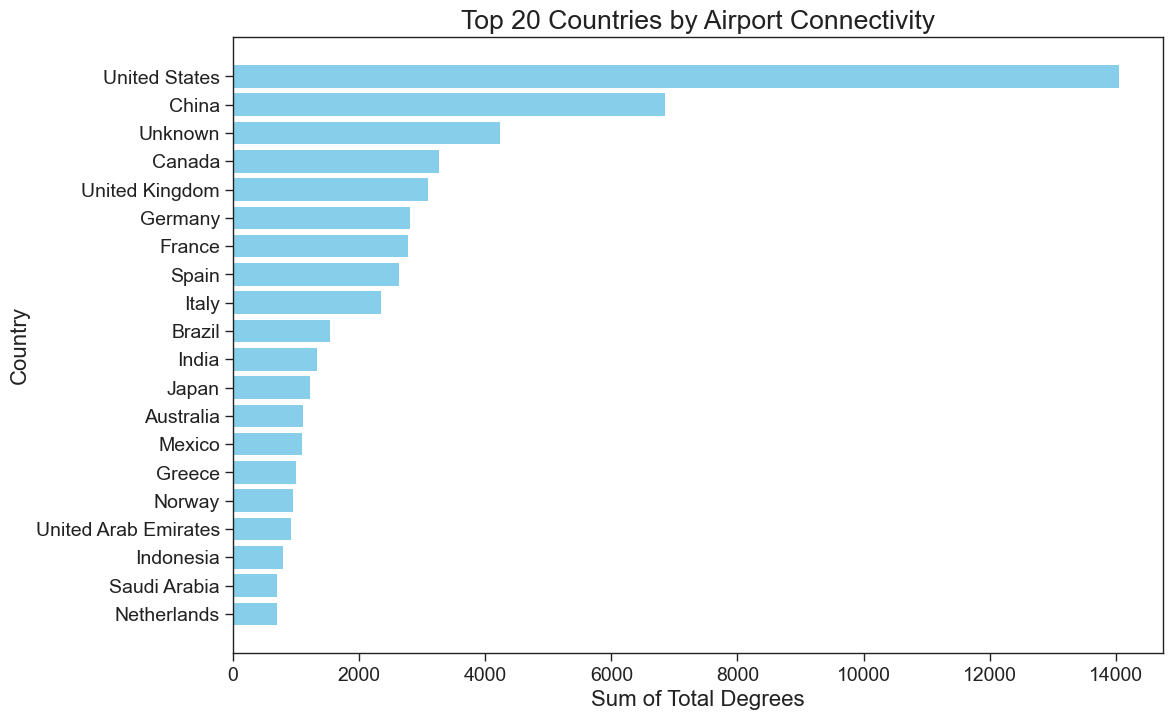

In [43]:
# Select the top N countries for visualization
top_countries = country_total_degree_sorted.head(20)
plt.figure(figsize=(12, 8))  
plt.barh(top_countries['Country'], top_countries['Total_Degree'], color='skyblue')  
plt.xlabel('Sum of Total Degrees') 
plt.ylabel('Country')  
plt.title('Top 20 Countries by Airport Connectivity') 
plt.gca().invert_yaxis()  # Invert the y-axis to have the country with the highest connectivity at the top
plt.show()


In [ ]:
# TODO
# Modify reverse geocode to find 'Unknown' continents. 
# Fix bug of reverse geocode function where if continent isn't found, it returns unknown country.